# Use Case Example: Fine Guidance Stars 

In [31]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (11, 10)

## Where's my stuff? (For this notebook only) 

In [33]:
import os
baseDir    = os.getenv("PLATO_PROJECT_HOME")
currentDir = os.getcwd()

import sys
sys.path.append(baseDir + "/python")

## Import the relevant modules

In [3]:
from numpy import *
from scipy import optimize
import matplotlib.cm as cm
import h5py
from simfile import SimFile
from simulation import Simulation
import referenceFrames as ref

## Make a proper input yaml file

I'm only showing some relevant fields of the inputfgs.yaml file.

General:
    
    ProjectLocation:             ENV['PLATO_PROJECT_HOME']

ObservingParameters:

    NumExposures:                1400 
    ExposureTime:                2.3 
    RApointing:                  86.79870
    DecPointing:                 -46.39595 
    StarCatalogFile:             inputfiles/guide_stars_EQ.txt

Platform:

    UseJitter:                   yes   
    UseJitterFromFile:           yes 
    JitterFileName:              inputfiles/PlatoJitter_Airbus.txt 

Telescope:

    AzimuthAngle:                1.0     
    TiltAngle:                   1.0     
    LightCollectingArea:         113.1   
    UseDrift:                    no

PSF:

    Model:                       Gaussian 
    Gaussian:                             
      Sigma:                     0.50     
      NumberOfPixels:            8        

SubField:    

    NumColumns:                  9  
    NumRows:                     9  
    SubPixels:                   512 

RandomSeeds:

    JitterSeed:                  1433320381 

## Where do the stars fall on the CCD?

### Getting access to the yaml input file

A 'Simulation' object provides easy access to all variables in the input yaml file.

In [4]:
inputFile = baseDir + "/inputfiles/inputfgs.yaml"

In [5]:
sim = Simulation("mySimulation", inputFile)

### Find out where the telescope points to

Beware of the difference between where the platform points to, and where the telescope points to. The azimuth and tilt of the telescope in the inputfile are merely an example.

In [6]:
RA_PLATFORM  = deg2rad(float(sim["ObservingParameters/RApointing"]))
DEC_PLATFORM = deg2rad(float(sim["ObservingParameters/DecPointing"]))

In [7]:
print("(RA, DEC) of the platform = ({0}, {1})".format(rad2deg(RA_PLATFORM), rad2deg(DEC_PLATFORM)))

(RA, DEC) of the platform = (86.7987, -46.39595)


In [8]:
azimuth = deg2rad(float(sim["Telescope/AzimuthAngle"]))
tilt    = deg2rad(float(sim["Telescope/TiltAngle"]))

In [9]:
RA_TELESCOPE, DEC_TELESCOPE = ref.platformToTelescopePointingCoordinates(RA_PLATFORM, DEC_PLATFORM, azimuth, tilt)

In [10]:
print("(RA, DEC) of the telescope = ({0}, {1})".format(rad2deg(RA_TELESCOPE), rad2deg(DEC_TELESCOPE)))

(RA, DEC) of the telescope = (86.7987, -46.395950000000006)


### Plotting the stars on the CCDs

In [11]:
starCatalog = baseDir + "/inputfiles/guide_stars_EQ.txt"
ra, dec, Vmag = loadtxt(starCatalog, unpack=True)
Nstars = len(ra)

In [14]:
focalPlaneAngle = float(sim["Camera/FocalPlaneOrientation"])
focalLength     = float(sim["Camera/FocalLength"])*1000.                       # [m] -> [mm]
pixelSize       = float(sim["CCD/PixelSize"])

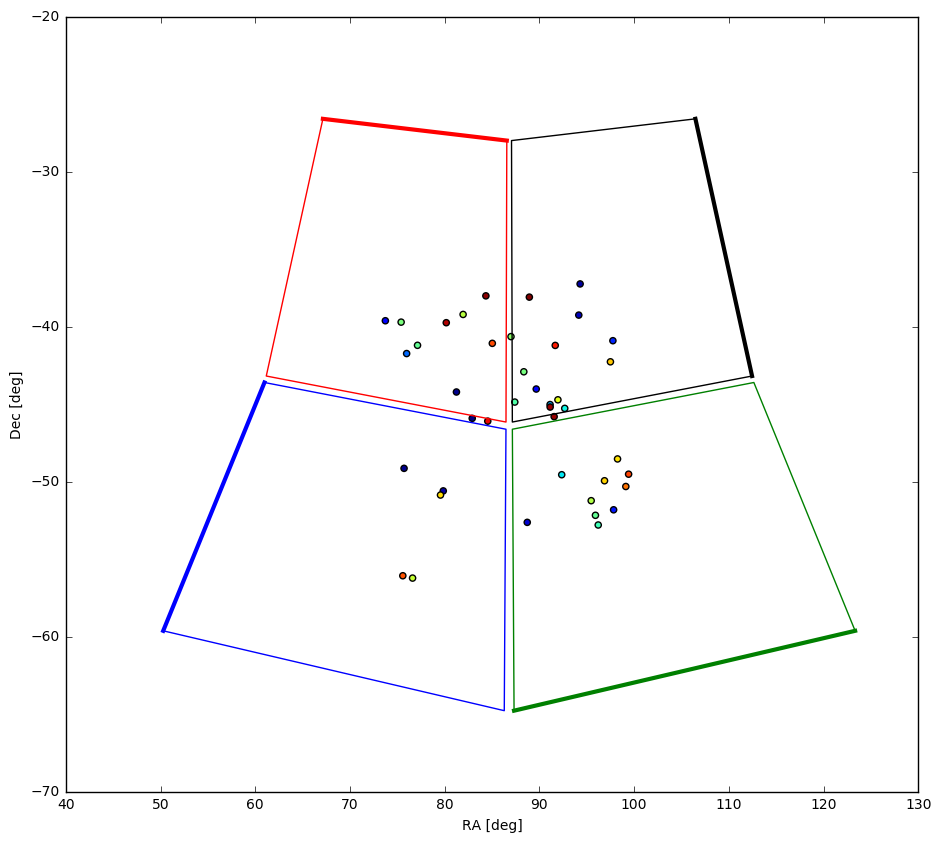

In [15]:
ref.drawCCDsInSky(RA_TELESCOPE, DEC_TELESCOPE, focalPlaneAngle, focalLength, pixelSize)
plt.scatter(ra, dec, c=Vmag)

Note that there are guidestars falling right in between the CCDs.

## Launch PlatoSim for each of the guide stars

In [16]:
for n in range(1):
    
    print("Running the simulator for guide star {0}".format(n))
    
    # Set up a Simulation object. Use a different run name for each star,
    # so that the outputfiles don't get mixed up.

    sim = Simulation("GuideStarSimulation{0:02d}".format(n), inputFile)
    sim.outputDir = currentDir
    
    # Put a small (9x9) subfield around the target star.
    # Beware, the guidestars are observed on the fast cameras, not the nominal ones. 
    
    fallsOnCCD = ref.setSubfieldAroundCoordinates(sim, deg2rad(ra[n]), deg2rad(dec[n]), 9, 9, normal=False)
    
    # If the star fell in between or outside the CCDs, simply ignore it
    
    if not fallsOnCCD:
        continue
    
    # Make sure that the random seeds are set different for each guide star, 
    # so that they have all different noise realisations.

    sim["RandomSeeds/PhotonNoiseSeed"]  = 1433237514 + n
    sim["RandomSeeds/ReadOutNoiseSeed"] = 1424949740 + n
    sim["RandomSeeds/FlatFieldSeed"]    = 1425284070 + n
    
    # Run PlatoSim!
    # simFile automatically let's you access the corresponding HDF5 outputfile
    
    simFile = sim.run()
    
    # In principle, you can continue from simFile and continue exploiting its contents.
    # In this example, we will split up the post-processing for the sake of clarity.

Running the simulator for guide star 0


In [17]:
%ls GuideStarSimulation*.hdf5

GuideStarSimulation00.hdf5


## Fitting the positions of the guidestars

### Plotting a subfield image

In [18]:
sim = SimFile("GuideStarSimulation00.hdf5")

In [19]:
image = sim.getImage(0)

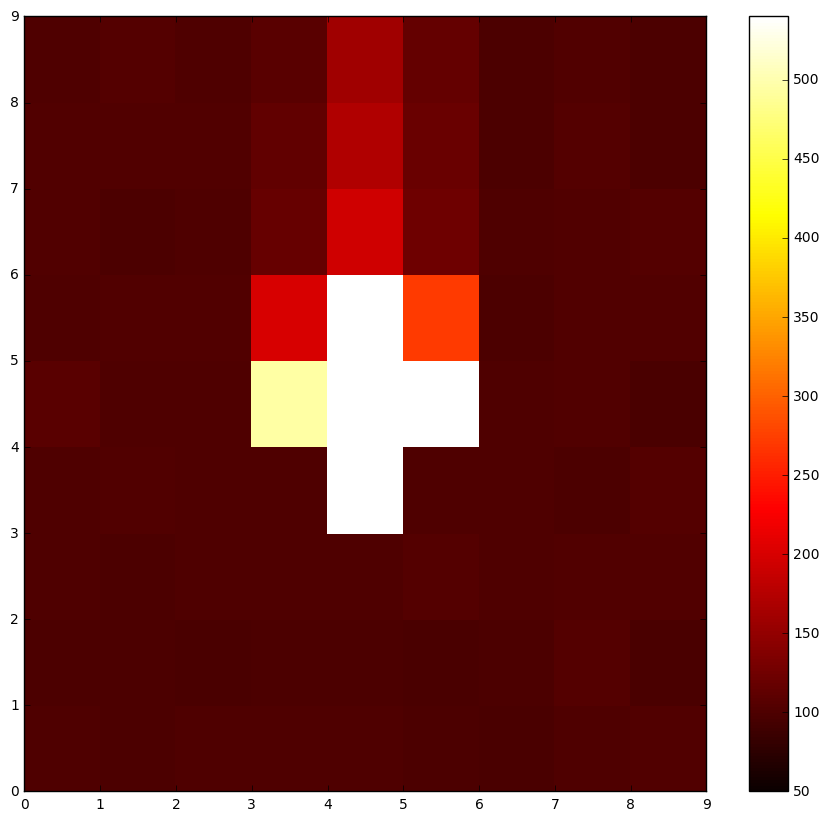

In [20]:
plt.pcolormesh(image, cmap=cm.hot, vmin=50, vmax=540)
plt.colorbar()

Note that the rows are counted in the y-direction (bottom-up), and the columns in the x-direction (left-right).

### Fit a 2D Gaussian to the first image

In [21]:
def gaussian(background, height, x0, y0, sigma):
    return lambda x,y: background + height*exp(-((x-x0)**2 + (y-y0)**2)/2.0/sigma**2)

Note that the x-direction corresponds here to the rows, and the y-direction to the columns.

In [22]:
def fitGaussian(image):
    residualFunction = lambda param: ravel(gaussian(*param)(*indices(image.shape)) - image)
    x0, y0 = unravel_index(image.argmax(), image.shape)
    initialEstimate = (median(image), image.max(), x0, y0, 0.5)               # (background, height, x0, y0, sigma)
    bestParam, success = optimize.leastsq(residualFunction, initialEstimate)
    return bestParam

Note: the unravel_index() construction is to find the (row,col) coordinates of the maximum element in the image.

In [23]:
bestFitParam = fitGaussian(image)
print("Center coordinates of Gaussian: (x,y)=({0},{1})".format(bestFitParam[2], bestFitParam[3]))
print("Height of the gaussian: {0}".format(bestFitParam[1]))
print("Stdev of the gaussian: {0}".format(bestFitParam[4]))
print("Background level: {0}".format(bestFitParam[0]))

Center coordinates of Gaussian: (x,y)=(4.413828420779366,4.028152094009539)
Height of the gaussian: 28249.839042968593
Stdev of the gaussian: 0.3943352091079439
Background level: 150.46568945538033


In [24]:
bestFit = gaussian(*bestFitParam)

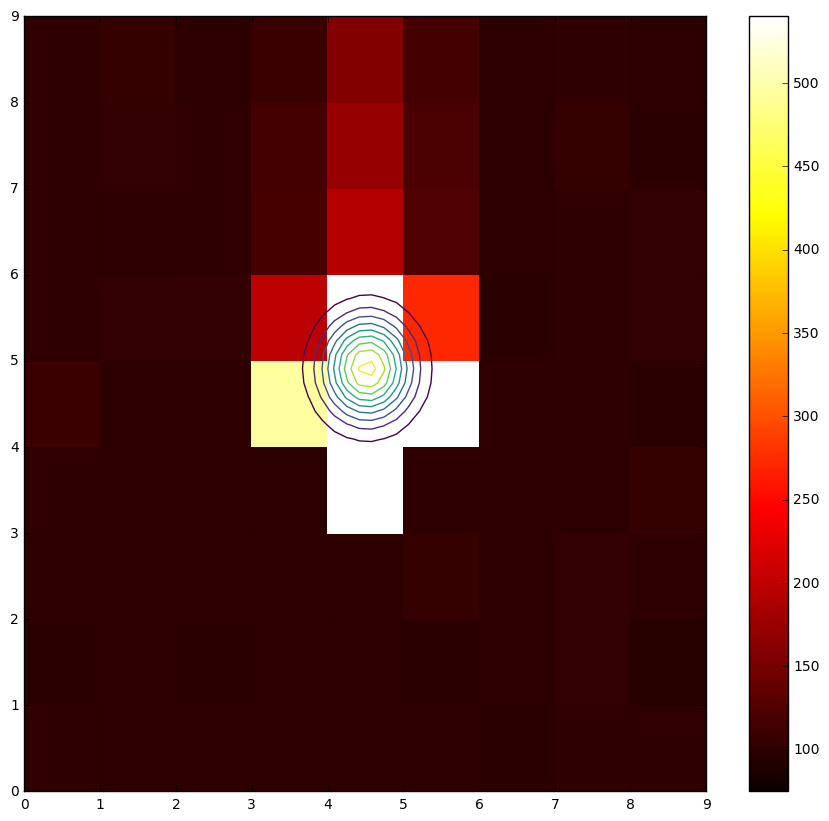

In [26]:
plt.pcolormesh(image, cmap=cm.hot, vmin=75, vmax=540)
plt.colorbar()
X, Y = mgrid[0:8:50j, 0:8:50j]
plt.contour(Y+0.5, X+0.5, bestFit(X, Y), 10, cmap=cm.viridis)

Note, for plotting, that contour() and pcolormesh() obey different conventions. pcolormesh() expects the x and y values to specify the corners of the individual pixels, while contour expects the centers of the pixels.

### Repeat the 2D fitting for all images

In [27]:
Nimages = sim.getInputParameter("ObservingParameters", "NumExposures")

Create a container for the fit parameters of all images:

In [28]:
fitParam = empty((Nimages, 5))

Loop over all images, and perform a 2D Gaussian fit:

In [29]:
for k in range(Nimages):
    image = sim.getImage(k)
    fitParam[k] = fitGaussian(image)

### Visualize the jitter of the Gaussian PSF

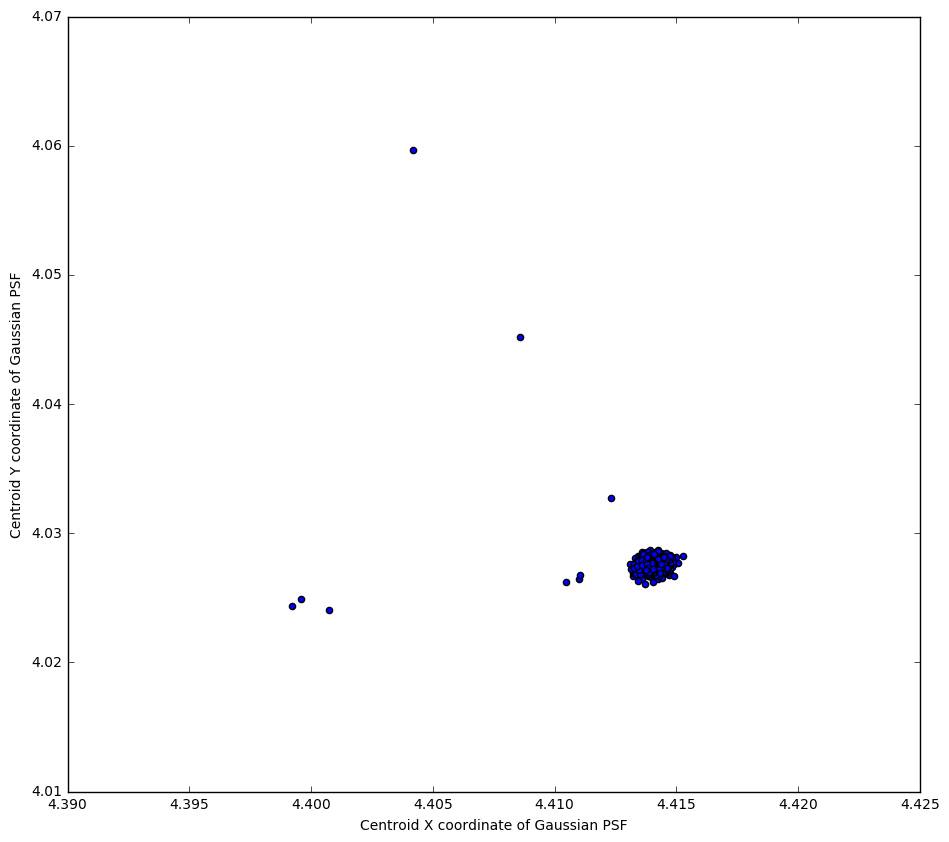

In [30]:
plt.scatter(fitParam[:,2], fitParam[:,3])
plt.xlabel("Centroid X coordinate of Gaussian PSF")
plt.ylabel("Centroid Y coordinate of Gaussian PSF")

### Extract the yaw, pitch, and roll values from the HDF5 file

In [34]:
outputFile = h5py.File("GuideStarSimulation00.hdf5")

First get the time points of the different exposures, which will be used later on to make a plot.

In [35]:
time1 = array(outputFile["/StarPositions/Time"])

Get the yaw, pitch, and roll. Note that the time series of these quantities has a finer time resolution

In [36]:
time2 = array(outputFile["/ACS/Time"])
yaw   = array(outputFile["/ACS/Yaw"])
pitch = array(outputFile["ACS/Pitch"])
roll  = array(outputFile["ACS/Roll"])

### Compare the yaw with the column coordinate

Scale and offset the different time series to make the plot more clear.

(0, 500)

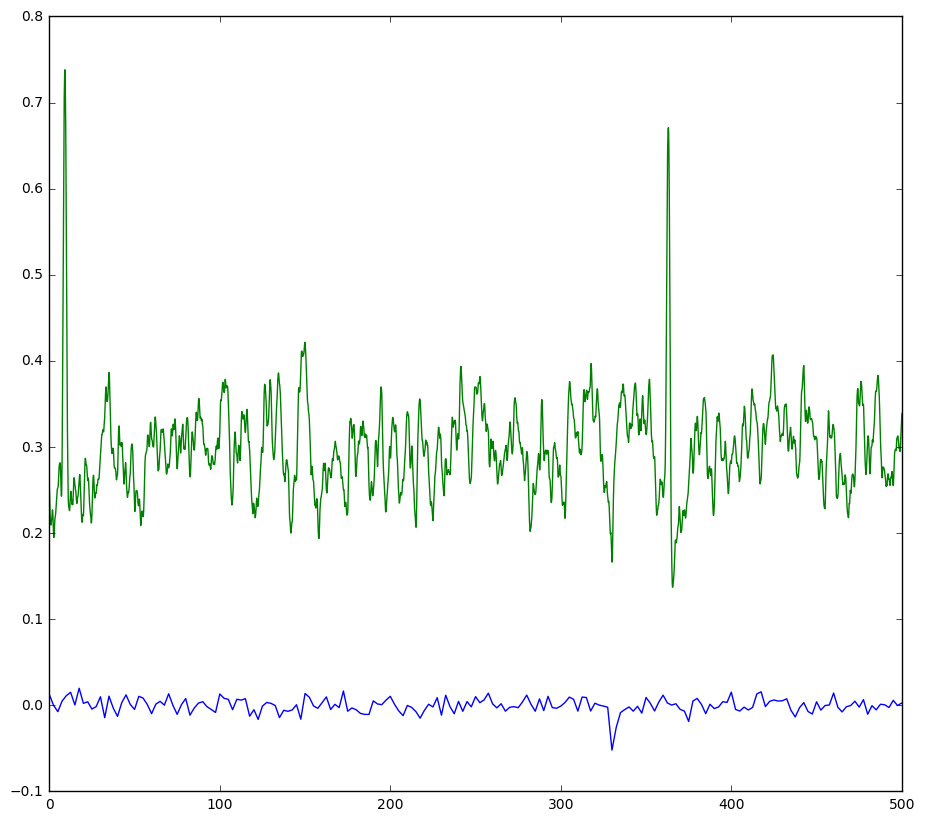

In [37]:
plt.plot(time1, 20 * (fitParam[:,3]-median(fitParam[:,3])))
plt.plot(time2,  yaw+0.3)
plt.xlim([0,500])

We clearly can reconstruct the yaw value by fitting a Gaussian to our PSFs.

### Compare the fitted column coordinate with the true column coordinate

Extract the true average column coordinate from the HDF5 file. 'Average' means time-averaged during the exposure.

In [38]:
trueCol = zeros(Nimages)
for k in range(Nimages):
    colPix = array(outputFile["/StarPositions/Exposure{0:06d}/colPix".format(k)])
    trueCol[k] = colPix[0]

Note that the true column coordinate colPix is an array, with one value per star. In this case, we only have 1 star in the subfield.

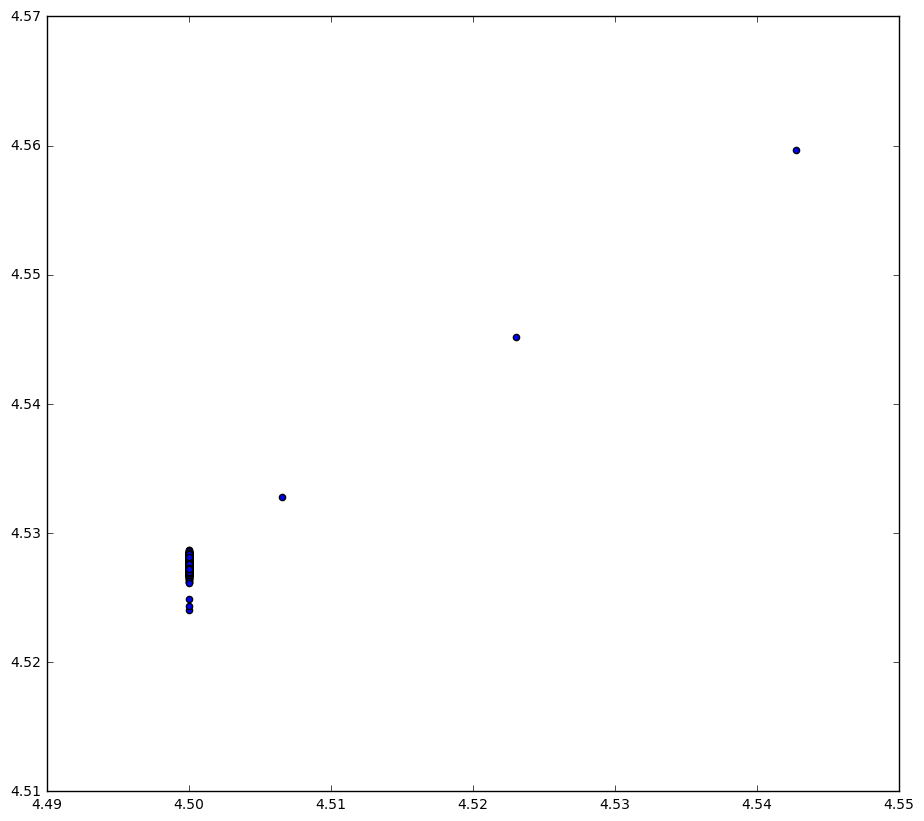

In [39]:
plt.scatter(trueCol, fitParam[:,3]+0.5)

The 0.5 offset is again because of the convention whether the coordinate is at the edge or in the middle of the pixel. The agreement seems very good.